<a href="https://colab.research.google.com/github/HalcyonForest/Time-Series-Forecasting/blob/main/HFT_11_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow
import xgboost as xgb
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
from keras import optimizers
from keras.layers import Bidirectional
from tensorflow.keras import regularizers
from keras.regularizers import l2
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [2]:
def split_sequences(sequences, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequences)):
  # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out-1
  # check if we are beyond the dataset
    if out_end_ix > len(sequences):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

def tickSlicing(data, tickRate, windowSize, predictSize):
  window_predict_in_seconds(tickRate, windowSize, predictSize)
  scaler = MinMaxScaler()
  data_scaled = df
  data_scaled[['CLOSE', 'VOL']] = scaler.fit_transform(data_scaled[['CLOSE', 'VOL']])
  data_scaled = data_scaled[::tickRate]
  data = data[::tickRate]
  #data_scaled = data_scaled[::tickRate]
  #print(data_scaled.head())

  X_close = np.reshape(np.array(data_scaled['CLOSE']), (len(data['CLOSE']),-1))
  X_vol = np.reshape(np.array(data_scaled['VOL']), (len(data['VOL']),-1))
  Y_close = np.reshape(np.array(data['CLOSE']), (len(data['CLOSE']), -1))
  data = []
  data = np.hstack((X_close, X_vol, Y_close))
  # Переделать под слайсинг двух параметров - Close + vol upd:DONE
  X, y = split_sequences(data, windowSize, predictSize)
  return X, y, scaler

def y_to_plot(y, y_step):
  y = np.reshape(y[::y_step], (-1))
  return y

def window_predict_in_seconds(tickrate, window, horizon):
  print("Смотрим каждый ", tickrate, "-ый тик, за последние ",tickrate * window / 12 ,"секунд")
  print("предсказываем на ",tickrate * horizon / 12 ," секунды вперед")

def error(X_test, y_test, model):
  y_pred = model.predict(X_test)
  y_pred = np.reshape(y_pred, (y_pred.shape[0], y_pred.shape[1]))
  error = mean_squared_error(y_pred, y_test)
  print(error)
  return error

def error_mae(X_test, y_test, model):
  y_pred = model.predict(X_test)
  y_pred = np.reshape(y_pred, (y_pred.shape[0], y_pred.shape[1]))
  error = mean_absolute_error(y_pred, y_test)
  print(error)
  return error

def plot_history(history_arr):
  for history in history_arr:
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train', 'validation'])
    plt.title('Loss')
    plt.show()

def unscaled_mse(scaler, X_test, y_test, model):
  y_test = scaler.inverse_transform(y_test)
  y_pred = model.predict(X_test)
  y_pred = scaler.inverse_transform(y_pred)
  error = mean_squared_error(y_pred, y_test)
  print("Real MSE error: ", error)
  return error

In [3]:
df = pd.read_csv('/content/drive/MyDrive/SBER_HFT_10D.csv')
df['DATE'] = df['<DATE>']
df['TIME'] = df['<TIME>']
df['CLOSE'] = df['<LAST>']
df['VOL'] = df['<VOL>']
df = df.drop(columns=['<DATE>', '<TIME>','<LAST>', '<VOL>'])
df['DATETIME'] = df['DATE'].astype(str) + df['TIME'].astype(str)
df['DATETIME'].head()
time = pd.to_datetime(df['DATETIME'], format='%Y%m%d%H%M%S')
df.index = time
df = df.drop(columns=['DATE', 'TIME', 'DATETIME'])
#df = df[:len(df)//2]

In [4]:
n_steps_in = 150 
n_steps_out = 14
tickrate = 2
df = df.iloc[:df.shape[0] // 2]
Xe, ye, scaler = tickSlicing(df, tickrate, n_steps_in, n_steps_out)
n_input = Xe.shape[1] * Xe.shape[2]
Xem = np.reshape(Xe, (Xe.shape[0], n_input))
Xm_train,Xm_test,ym_train, ym_test = train_test_split(Xe, ye, test_size=0.7, shuffle=False) 
Xe.shape

Смотрим каждый  2 -ый тик, за последние  25.0 секунд
предсказываем на  2.3333333333333335  секунды вперед


(211110, 150, 2)

In [6]:
def GetModel(nodes, layers, epochs, dropout,batch_size,learning_rate, X_train, y_train, X_test, y_test):
  dense_nodes = nodes
  model_lstm = Sequential()
  model_lstm.add(LSTM(nodes, activation='relu', input_shape=(n_steps_in, Xe.shape[2]), return_sequences=(layers>1),
                      kernel_regularizer=l2(0.00001), activity_regularizer=l2(0.00001)))
  for i in range(1,layers):
    model_lstm.add(LSTM((nodes // 2), activation='relu', return_sequences=(i < layers-1), kernel_regularizer=l2(0.00001), 
               activity_regularizer=l2(0.00001) ))
    nodes = nodes // 2
  model_lstm.add(Dense(dense_nodes*10, activation='relu', kernel_regularizer=l2(0.000001)))
  model_lstm.add(Dropout(dropout))
  model_lstm.add(Dense(n_steps_out, activation='relu', kernel_regularizer=l2(0.000001)))
  optAdam = optimizers.Adam(clipnorm=0.5, learning_rate = learning_rate, clipvalue=0.5)
  # optSGD = optimizers.SGD(lr=0.001, momentum=0.9, clipnorm=0.5, clipvalue=1.0)
  model_lstm.compile(optimizer=optAdam, loss='mae',
    #metrics=[tf.keras.metrics.MeanAbsolutePercentageError]
    )
  history = model_lstm.fit(X_train, y_train, epochs = epochs, verbose=1, batch_size = batch_size, validation_data=(X_test, y_test), callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
  err_mlp = error_mae(X_test, y_test, model_lstm)
  return history, err_mlp, model_lstm
 
def NodeSearch(params, X_train, y_train, X_test, y_test):
  hys = []
  errors = []
  for param in params:
    hystory, error = GetModel(param, layers=1, epochs=100, dropout=0.35, X_train=X_train, y_train=y_train , X_test=X_test, y_test=y_test)
    hys.append(hystory)
    errors.append(error)
    print("Nodes: ", param, "MAE error: ", error)
  return hys, errors
 
def LayersSearch(params, X_train, y_train, X_test, y_test):
  hys = []
  errors = []
  for param in params:
    hystory, error = GetModel(nodes=50, layers=param, epochs=20, dropout=0.35, X_train=X_train, y_train=y_train , X_test=X_test, y_test=y_test)
    hys.append(hystory)
    errors.append(error)
    print("Layers: ", param, "MAE error: ", error)
  return hys, errors
 
def BatchSizeSearch(params, X_train, y_train, X_test, y_test):
  hys = []
  errors = []
  for param in params:
    hystory, error = GetModel(nodes=50, layers=1, epochs=40, dropout=0.35, batch_size=param,learning_rate=0.0001, X_train=X_train, y_train=y_train , X_test=X_test, y_test=y_test)
    hys.append(hystory)
    errors.append(error)
    print("Layers: ", param, "MAE error: ", error)
  return hys, errors

def LearningRateSearch(params, X_train, y_train, X_test, y_test):
  hys = []
  errors = []
  for param in params:
    hystory, error = GetModel(nodes=50, layers=1, epochs=40, dropout=0.35, batch_size=1000,learning_rate=param, X_train=X_train, y_train=y_train , X_test=X_test, y_test=y_test)
    hys.append(hystory)
    errors.append(error)
    print("Layers: ", param, "MAE error: ", error)
  return hys, errors

In [7]:
nodes = [10, 20, 30, 40, 50]
layers = [1,3]
epochs = [50,100,150]
dropout = [0.1,0.25,0.4]
batch_sizes = [50, 200, 1000, 5000, 10000]
learning_rates = [0.0005, 0.0001, 0.00005, 0.00001, 0.000001]

In [ ]:
%%time
#nodes_hys, nodes_errors = NodeSearch(nodes, Xm_train, ym_train, Xm_test, ym_test)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs


In [ ]:
%%time
layerss_hys, layers_errors = LayersSearch(layers, Xm_train, ym_train, Xm_test, ym_test)

Epoch 1/20
7917/7917 [==============================] - 435s 55ms/step - loss: 0.1882 - val_loss: 0.0073
Epoch 2/20
7917/7917 [==============================] - 438s 55ms/step - loss: 0.0322 - val_loss: 0.0077
Epoch 3/20
7917/7917 [==============================] - 435s 55ms/step - loss: 0.0258 - val_loss: 0.0041
Epoch 4/20
7917/7917 [==============================] - 439s 55ms/step - loss: 0.0225 - val_loss: 0.0059
Epoch 5/20
7917/7917 [==============================] - 435s 55ms/step - loss: 0.0203 - val_loss: 0.0051
Epoch 6/20
7917/7917 [==============================] - 440s 56ms/step - loss: 0.0189 - val_loss: 0.0038
Epoch 7/20
7917/7917 [==============================] - 437s 55ms/step - loss: 0.0178 - val_loss: 0.0050
Epoch 8/20
7917/7917 [==============================] - 442s 56ms/step - loss: 0.0169 - val_loss: 0.0038
Epoch 9/20
7917/7917 [==============================] - 439s 55ms/step - loss: 0.0162 - val_loss: 0.0052
Epoch 10/20
7917/7917 [==============================] 

In [ ]:
print(nodes_errors)
#plot_history(nodes_hys)
# nodes: 10          20      30      40       50
#val_loss: 0.00301, 0.018697, 0.024, | epochs = 30
# epochs = 100 
# val_loss: 0.0305, 0.0251, 0.0190, 0.0189, 0.0168
# epochs = 60, lstm_dropout =0.1 batch_size =2000 dropout =0.35
#layers = 1   2    3     4     5
#val_loss 0.00883 x x x x
# layers = 1         2         3 
# nodes=30, epochs=60, dropout=0.35, rec_do = 0 batch_size = 5000
#errors = 0.0049, 0.00592, 0.00590
# layers = 1, 4
# nodes = 50, epochs = 60, dropout = 0.4 batch_size = 200
#erros = 0.011 0.0081
# layers = 1, 4
# nodes = 50, epochs = 60, dropout = 0.4 batch_size = 32
#erros = 0.011 0.0081
# layers = 1, 3
# nodes = 50, epochs = 40, dropout = 0.4 batch_size = 4 learning_rate = 0.0001 layers = 1
#erros = 0.00356

[0.011106113451873373, 0.008198109690156316]


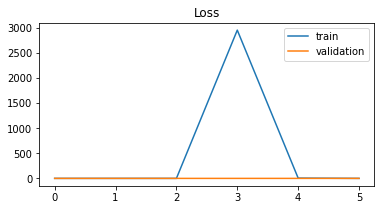

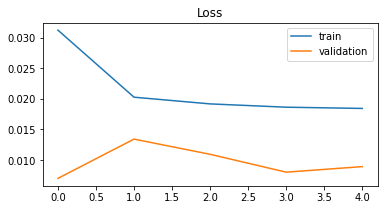

In [ ]:
print(layers_errors)
plot_history(layerss_hys)
#layers: 1, 2, 3, 4 (w\o recrnt dropout)
#errors: 0.168 0.0050, 0.0049, 0.0052
#layers: 1, 2, 5 (rcrnt dropout = 0.35)
#errors: 0.0088, 0.026, 640.2438678968028, 14.284209401626908

In [ ]:
hystory, error = GetModel(nodes=200, layers=1, epochs=100, dropout=0.4,batch_size=500, learning_rate = 0.00001, X_train=Xm_train, y_train=ym_train , X_test=Xm_test, y_test=ym_test)
print("Layers: ", 200, "lr: ", 0.00001 , "MAE error: ", error)

Epoch 1/100
254/254 [==============================] - 545s 2s/step - loss: 0.4419 - val_loss: 0.1603
Epoch 2/100
254/254 [==============================] - 533s 2s/step - loss: 0.0665 - val_loss: 0.0223
Epoch 3/100
254/254 [==============================] - 534s 2s/step - loss: 0.0393 - val_loss: 0.0075
Epoch 4/100
254/254 [==============================] - 527s 2s/step - loss: 0.0312 - val_loss: 0.0048
Epoch 5/100
254/254 [==============================] - 517s 2s/step - loss: 0.0287 - val_loss: 0.0051
Epoch 6/100
254/254 [==============================] - 520s 2s/step - loss: 0.0268 - val_loss: 0.0050
Epoch 7/100
254/254 [==============================] - 515s 2s/step - loss: 0.0254 - val_loss: 0.0058
Epoch 8/100
254/254 [==============================] - 524s 2s/step - loss: 0.0241 - val_loss: 0.0050
Epoch 9/100
254/254 [==============================] - 514s 2s/step - loss: 0.0229 - val_loss: 0.0043
Epoch 10/100
254/254 [==============================] - 521s 2s/step - loss: 0.022

In [12]:
print(error)

0.0033826833377059184


In [ ]:
unscaled_mse(scaler, Xm_test, ym_test,)

In [ ]:
%%time
batch_hys, batch_errors = BatchSizeSearch(batch_sizes[3:], Xm_train, ym_train, Xm_test, ym_test)

Epoch 1/40
26/26 [==============================] - 80s 3s/step - loss: 0.4594 - val_loss: 0.5614
Epoch 2/40
26/26 [==============================] - 77s 3s/step - loss: 0.4299 - val_loss: 0.5067
Epoch 3/40
26/26 [==============================] - 76s 3s/step - loss: 0.3721 - val_loss: 0.3953
Epoch 4/40
26/26 [==============================] - 77s 3s/step - loss: 0.2616 - val_loss: 0.1435
Epoch 5/40
26/26 [==============================] - 76s 3s/step - loss: 0.1080 - val_loss: 0.0685
Epoch 6/40
26/26 [==============================] - 77s 3s/step - loss: 0.0771 - val_loss: 0.0410
Epoch 7/40
26/26 [==============================] - 77s 3s/step - loss: 0.0677 - val_loss: 0.0338
Epoch 8/40
26/26 [==============================] - 77s 3s/step - loss: 0.0586 - val_loss: 0.0262
Epoch 9/40
26/26 [==============================] - 77s 3s/step - loss: 0.0504 - val_loss: 0.0177
Epoch 10/40
26/26 [==============================] - 77s 3s/step - loss: 0.0452 - val_loss: 0.0122
Epoch 11/40
26/26 [

KeyboardInterrupt: ignored

In [ ]:
#other hps: nodes=50, layers=1, epochs=20, dropout=0.35, batch_size=param,learning_rate=0.0001
#times per epoch 450s    120s       90s
# batch sizes = 50      200     1000     5000     10000
#errors  =     0.00369 0.00366 0.00361    0.0054     *помойка

#nodes=80, layers=1, epochs=100, dropout=0.4,batch_size=1000, learning_rate = 0.00005
#error = 0.003312

In [ ]:
print(batch_errors)
plot_history(batch_hys)

In [ ]:
%%time
lr_hys, lr_errors = LearningRateSearch(learning_rates, Xm_train, ym_train, Xm_test, ym_test)

Epoch 1/40
127/127 [==============================] - 91s 705ms/step - loss: 0.2588 - val_loss: 0.0080
Epoch 2/40
127/127 [==============================] - 90s 707ms/step - loss: 0.0338 - val_loss: 0.0048
Epoch 3/40
127/127 [==============================] - 90s 710ms/step - loss: 0.0265 - val_loss: 0.0037
Epoch 4/40
127/127 [==============================] - 90s 710ms/step - loss: 0.0227 - val_loss: 0.0039
Epoch 5/40
127/127 [==============================] - 90s 707ms/step - loss: 0.0206 - val_loss: 0.0063
Epoch 6/40
127/127 [==============================] - 90s 707ms/step - loss: 0.0191 - val_loss: 0.0049
Epoch 7/40
127/127 [==============================] - 89s 706ms/step - loss: 0.0179 - val_loss: 0.0034
Epoch 8/40
127/127 [==============================] - 89s 703ms/step - loss: 0.0171 - val_loss: 0.0035
Epoch 9/40
127/127 [==============================] - 90s 706ms/step - loss: 0.0163 - val_loss: 0.0034
Epoch 10/40
127/127 [==============================] - 90s 707ms/step - l

In [ ]:
print(lr_errors)
plot_history(lr_hys)

In [59]:
#nodes=80, layers=1, epochs=100, dropout=0.4,batch_size=1000, learning_rate = 0.00005
#error = 0.003312
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(n_steps_in, Xe.shape[2]), return_sequences=1,
                      kernel_regularizer=l2(0.001), activity_regularizer=l2(0.001)))
model_lstm.add(LSTM(32, activation='relu', return_sequences=1, kernel_regularizer=l2(0.00001), activity_regularizer=l2(0.00001) ))
model_lstm.add(LSTM(16, activation='relu', return_sequences=0, kernel_regularizer=l2(0.00001), activity_regularizer=l2(0.00001) ))
#nodes = nodes // 2
model_lstm.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(n_steps_out, activation='relu', kernel_regularizer=l2(0.0001)))
optAdam = optimizers.Adam(clipnorm=0.5, learning_rate = 0.0002, clipvalue=0.5)
  # optSGD = optimizers.SGD(lr=0.001, momentum=0.9, clipnorm=0.5, clipvalue=1.0)
model_lstm.compile(optimizer=optAdam, loss='mse'
                   #tf.keras.losses.MeanAbsolutePercentageError(
    #reduction="auto", name="mean_absolute_percentage_error"),
    #metrics=[tf.keras.metrics.MeanAbsolutePercentageError]
    )
#history = model_lstm.fit(Xm_train, ym_train, epochs = 30, verbose=1, batch_size = 512, validation_data=(Xm_test, ym_test), callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4))
#err_mlp = error_mae(Xm_test, ym_test, model_lstm)
#umse = unscaled_mse(scaler, Xm_test, ym_test, model_lstm)

0.019881462984397375
Error LSTM:  0.019881462984397375


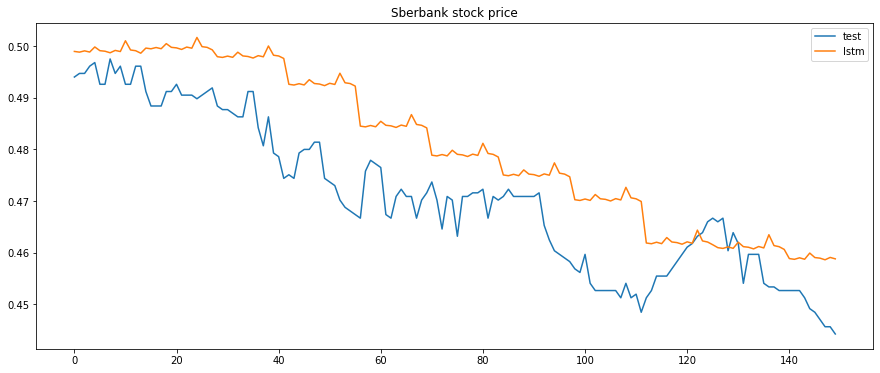

In [56]:
mse_lstm = error(Xm_test, ym_test, model_lstm)
real_mse = mse_lstm * (max(df['CLOSE']) - min(df['CLOSE'])) ** 2
#print(real_mse)
print("Error LSTM: ", real_mse)
y_pred = model_lstm.predict(Xm_test)
y_pred_plot = y_to_plot(y_pred, 14)
ym_test_plot = y_to_plot(ym_test, 14)
plt.figure(figsize=(15,6))
plt.plot(ym_test_plot[:150])
plt.plot(y_pred_plot[:150])
plt.legend(['test', 'lstm'])
plt.title('Sberbank stock price')
plt.show()

In [47]:
# 0.014763186840567433
mse_lstm = error(Xm_test, ym_test, model_lstm)
real_mse = mse_lstm * (max(df['CLOSE']) - min(df['CLOSE'])) ** 2
print(real_mse)

0.010487209057845408
0.010487209057845408


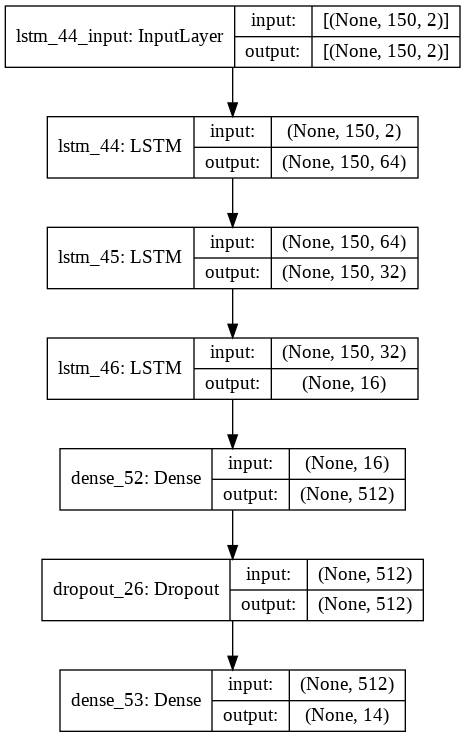

In [60]:
tf.keras.utils.plot_model(model_lstm, show_shapes=True, show_layer_names=True,expand_nested=True)

In [12]:
mse_lstm = error(Xm_test, ym_test, model_lstm)
real_mse = mse_lstm * (max(df['CLOSE']) - min(df['CLOSE'])) ** 2
print(real_mse)

0.007481163878337513
0.007481163878337513


0.007481163878337513
Error LSTM:  0.007481163878337513


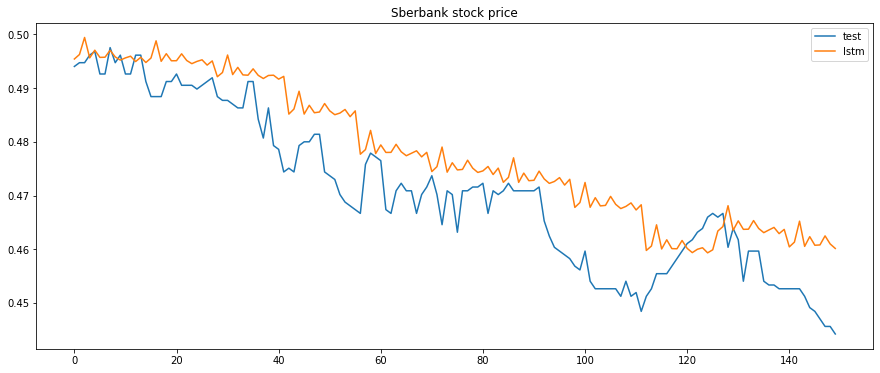

In [21]:
mse_lstm = error(Xm_test, ym_test, model_lstm)
real_mse = mse_lstm * (max(df['CLOSE']) - min(df['CLOSE'])) ** 2
#print(real_mse)
print("Error LSTM: ", real_mse)
y_pred = model_lstm.predict(Xm_test)
y_pred_plot = y_to_plot(y_pred, 14)
ym_test_plot = y_to_plot(ym_test, 14)
plt.figure(figsize=(15,6))
plt.plot(ym_test_plot[:150])
plt.plot(y_pred_plot[:150])
plt.legend(['test', 'lstm'])
plt.title('Sberbank stock price')
plt.show()

In [62]:
y_pred = model_lstm.predict(Xm_test)
y_pred_plot = y_to_plot(y_pred, 14)

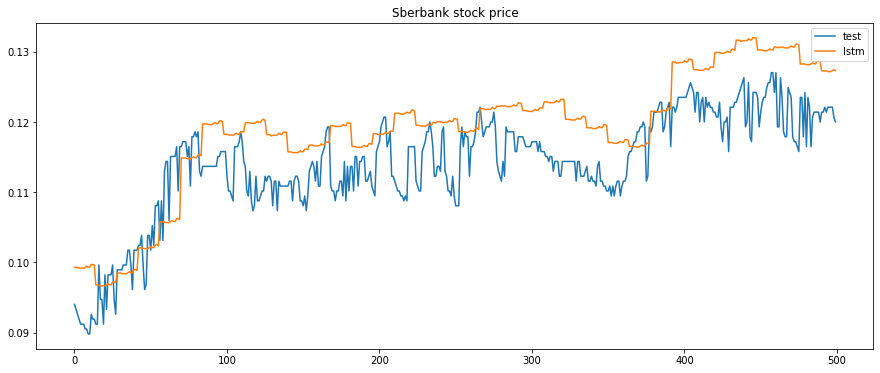

In [65]:
ym_test_plot = y_to_plot(ym_test, 14)
plt.figure(figsize=(15,6))
plt.plot(ym_test_plot[:500])
plt.plot(y_pred_plot[:500])
plt.legend(['test', 'lstm'])
plt.title('Sberbank stock price')
plt.show()

In [56]:
def unscaled_mse(scaler, X_test, y_test, model):
  print(np.array(df['CLOSE']))
  scaler = MinMaxScaler()
  scaler.fit(np.array(df['CLOSE']))
  print(y_test.shape)
  y_test = scaler.inverse_transform(y_test)
  print(y_test.shape)
  y_pred = model.predict(X_test)
  print(y_pred.shape, y_test.shape)
  y_pred = scaler.inverse_transform(y_pred)
  print(y_pred.shape)
  y_pred = np.reshape(y_pred, (y_pred.shape[0], y_pred.shape[1]))
  error = mean_squared_error(y_pred, y_test)
  print("Real MSE error: ", error)
  return error

In [ ]:
umse = unscaled_mse(scaler, Xm_test, ym_test, model_lstm)

In [29]:
print(Xe.shape, Xm_train[:, :,0].shape, Xm_test[:, :,0].shape, ym_train.shape, ym_test.shape)

(211110, 150, 2) (63333, 150) (147777, 150) (63333, 14) (147777, 14)


In [27]:
Xm_train[:, :,0].shape

(63333, 150)

In [ ]:
xmr_train = 
xmr_test = 

In [31]:
model_ed2 = Sequential()
model_ed2.add(LSTM(40, activation='relu', input_shape=(n_steps_in,1)))
model_ed2.add(RepeatVector(n_steps_out))
model_ed2.add(LSTM(20, activation='relu', return_sequences=True))
model_ed2.add(TimeDistributed(Dense(250)))
model_ed2.add(Dropout(0.4))
model_ed2.add(Dense(n_steps_out, activation='relu'))
model_ed2.compile(optimizer='adam', loss='mse')
model_ed2.fit(Xm_train[:, :,0], ym_train, epochs = 20, verbose=1, batch_size = 200, validation_data=(Xm_test[:, :,0], ym_test), callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
err_ed2 = error(Xm_test[:, :,0], ym_test, model_ed2)

Epoch 1/20


ValueError: ignored

In [ ]:
mse_edlstm = error(Xm_test, ym_test, model_ed2)
ed_mse = mse_edlstm * (max(df['CLOSE']) - min(df['CLOSE'])) ** 2
#print(real_mse)
print("Error Encoder-Decoder LSTM: ", ed_mse)
y_pred_ed = model_ed2.predict(Xm_test)
y_pred_plot_ed = y_to_plot(y_pred, 14)
ym_test_plot = y_to_plot(ym_test, 14)
plt.figure(figsize=(15,6))
plt.plot(ym_test_plot[:500])
plt.plot(y_pred_plot_ed[:500])
plt.legend(['test', 'Enocder-Decoder lstm'])
plt.title('Sberbank stock price')
plt.show()